In [1]:
import pandas as pd 
from sqlalchemy import create_engine
import matplotlib.pyplot as plt  
import numpy as np
from scipy import stats
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from scipy.stats import norm
import time
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy import create_engine


pd.set_option('display.max_columns', 500)

In [2]:
import pickle
df = pickle.load(open('../back_test_sample.sav', 'rb'))
last_row = 0
for index, row in df.dropna().iterrows():
    ok = True
    if last_row == 0:
        last_row = row['date']
        continue
    if row['date'] - last_row  != 14400:
        print('Not consistent')
        print(row.date)
        print(last_row)
    #df.loc[df.index==index, 'dif'] = row['date'] - last_row 
    last_row = row['date']
#df[['date', 'dif']]

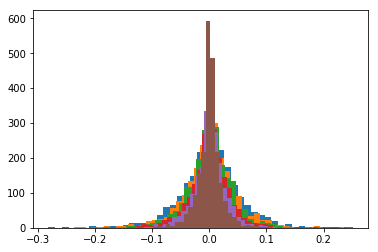

In [3]:
plt.hist(df.target_log_return_6, bins=45)
plt.hist(df.target_log_return_5, bins=45)
plt.hist(df.target_log_return_4, bins=45)
plt.hist(df.target_log_return_3, bins=45)
plt.hist(df.target_log_return_2, bins=45)
plt.hist(df.target_log_return_1, bins=45)
plt.show()

In [4]:
def get_x_y(target_value, features_df):
    targets = ['target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6',]
    
    mask = (
       ((features_df['target_log_return_1'] >= target_value)
        | (features_df['target_log_return_2'] >= target_value) 
        | (features_df['target_log_return_3'] >= target_value) 
        | (features_df['target_log_return_4'] >= target_value)
        | (features_df['target_log_return_5'] >= target_value)
        | (features_df['target_log_return_6'] >= target_value))
           )
    features_df.loc[mask, 'target_sign'] = 1
    features_df.loc[~mask, 'target_sign'] = 0
    
    drop_columns = ['coin', 'date', 'period', 
                'high', 'low', 'open', 'close', 'volume', 'quote_volume',
                'weightedAverage',
                'BBUpper', 'BBLower', 'BBMiddle',
                'EMA9', 'EMA12', 'EMA26', 'EMA50',
                'SMA9', 'SMA12', 'SMA26', 'SMA50',
                'target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6',
              'mean_return', 'variance', 'stdev'
               ]

    # Preparing dataframe
    clean_df = features_df.drop(drop_columns, axis=1).copy()
    # Defining Features (X) and Target Variable (y)
    
    returns = []
    for t in targets:
        returns.append(features_df.loc[features_df['target_sign'] == 0][t].values)

    flat_missed_list = [item for sublist in returns for item in sublist if not math.isnan(item)]

    returns = []
    for t in targets:
        returns.append(features_df.loc[features_df['target_sign'] == 1][t].values)

    flat_list = [item for sublist in returns for item in sublist if not math.isnan(item)]
    
    
    X = clean_df.drop(['target_sign'], axis =1)
    y = clean_df[['target_sign']]
    
    return X, y, flat_missed_list, flat_list
    
    

In [5]:
def run_model(X_sample, y_sample, target_value, threshold,  model):
    scaler = MinMaxScaler().fit(X_sample)
    X_sample = scaler.transform(X_sample)
    # Split Train, Test
    X_train, X_test = X_sample[:math.floor(len(X_sample) * 0.75)], X_sample[math.ceil(len(X_sample) * 0.75):]
    y_train, y_test = y_sample.iloc[:math.floor(len(y_sample) * 0.75)], y_sample.iloc[math.ceil(len(y_sample) * 0.75):]

    # Rebalance Samples
    oversampler = SMOTE(random_state=42)
    X_train, y_train = oversampler.fit_sample(X_train, y_train.target_sign)
    # (Re) define Models
    model.fit(X_train, y_train)
    predicted_proba = model.predict_proba(X_test)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    precision = precision_score(y_test, predicted)
    train_acc = accuracy_score(y_test, predicted)
    return {
        'Precision': precision,
        'Accuracy': train_acc,
        'Trades': np.sum(predicted),
        'Real Profits': np.sum(y_test)[0],
        'Target': target_value,
        'Scaler': scaler,
        'Model': model
    }

In [6]:
def estimate_best_stop_loss(flat_missed_list, flat_list, TP, P):
    risk_free = ((1 + 0.065) ** (1/252) - 1)
    simulations = []
    ps = 0.05
    while ps < 1:
        SL = np.percentile(flat_missed_list, ps*100)
        if SL < -3 * TP or SL > -0.01 :
            ps += 0.05
            continue
        P_stop_loss_right = len([f for f in flat_list if f <= SL])/len(flat_list)
        Mean_return_wrong = np.percentile(flat_missed_list, 15)
        ER = P * (1 - P_stop_loss_right) * TP + P * P_stop_loss_right * SL + (1 - P) * (1 - ps) * Mean_return_wrong  + (1 - P) * ps * SL
        simulations.append({
            'ER': ER,
            'Probability Stop Loss Miss': ps,
            'Probability Stop Loss Right': P_stop_loss_right,
            'Stop_Loss': SL,
            'Multiple': ER/risk_free,
            'Precision': P,
            'Take_profit': TP
        })
        ps += 0.05
    return sorted(simulations, key = lambda i: i['ER'], reverse=True)[0]
    

In [7]:
training_window = 70 # days
sample_model = training_window * (86400/14400)
retraining_model = 5
target_value = 0.03
threshold = 0.7

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Extra Tree': ExtraTreesClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boost': GradientBoostingClassifier(random_state=42)
}
drop_columns = ['coin', 'date', 'period', 
                'high', 'low', 'open', 'close', 'volume', 'quote_volume',
                'weightedAverage',
                'BBUpper', 'BBLower', 'BBMiddle',
                'EMA9', 'EMA12', 'EMA26', 'EMA50',
                'SMA9', 'SMA12', 'SMA26', 'SMA50',
                'target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6',
              'mean_return', 'variance', 'stdev'
               ]


back_test = df.copy()
for index, row in back_test.iterrows():
    signal = 0
    current_date = row['date']
    base_date = current_date - training_window * 6 * 14400
    model_sample = back_test.loc[(back_test.date >= base_date) & (back_test.date < current_date)].copy()
    if len(model_sample) < sample_model:
        continue
    X, y, flat_missed_list, flat_list = get_x_y(target_value, model_sample)
    model = run_model(X, y, target_value, threshold, models['Random Forest'])
    df.loc[df.date == current_date, 'Model_Precision'] = model['Precision']
    if model['Precision'] < 0.5:
        continue
    best_parameters_model = estimate_best_stop_loss(flat_missed_list, flat_list, target_value, model['Precision'])
    if best_parameters_model and best_parameters_model['ER'] > 0: 
        X = row.drop(drop_columns)
        X = model['Scaler'].transform(X.ravel().reshape(1, -1))
        predicted_proba = model['Model'].predict_proba(X)
        if predicted_proba[0][1] > threshold:
            signal = 1
        df.loc[df.date == current_date, 'Model_ER'] = best_parameters_model['ER']
        df.loc[df.date == current_date, 'Model_TP'] = best_parameters_model['Take_profit']
        df.loc[df.date == current_date, 'Model_SL'] = best_parameters_model['Stop_Loss']
        df.loc[df.date == current_date, 'Signal'] = signal

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set

In [8]:
sum(df.dropna().Signal)

31.0

In [9]:
back_test_df = df.loc[(df['Signal'] == 1)].dropna().copy()

In [10]:
for index, row in back_test_df.iterrows():
    if ((row['target_log_return_1'] >= row['Model_TP'])
    or (row['target_log_return_2'] >= row['Model_TP'])
    or (row['target_log_return_3'] >= row['Model_TP'])
    or (row['target_log_return_4'] >= row['Model_TP'])
    or (row['target_log_return_5'] >= row['Model_TP'])
    or (row['target_log_return_6'] >= row['Model_TP'])):
        back_test_df.loc[back_test_df.index==index, 'profit'] = row['Model_TP']
    elif ((row['target_log_return_1'] <= row['Model_SL'])
        or (row['target_log_return_2'] <= row['Model_SL'])
        or (row['target_log_return_3'] <= row['Model_SL'])
        or (row['target_log_return_4'] <= row['Model_SL'])
        or (row['target_log_return_5'] <= row['Model_SL'])
        or (row['target_log_return_6'] <= row['Model_SL'])):
        back_test_df.loc[back_test_df.index==index, 'profit'] = row['Model_SL']
    else:
        back_test_df.loc[back_test_df.index==index, 'profit'] = row['target_log_return_6']
    
    

In [11]:
investment = 100
back_test_df.profit.sum()*investment

34.831590074744184

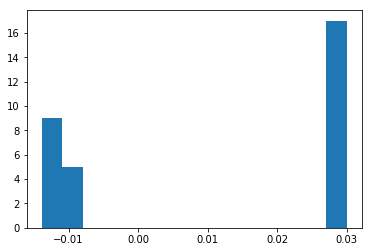

In [12]:
plt.hist(back_test_df.profit, bins=15)
plt.show()

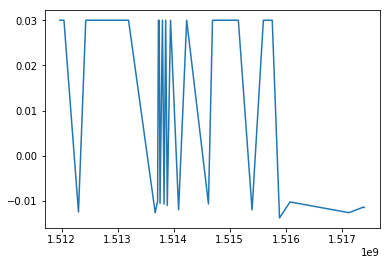

In [13]:
plt.plot(back_test_df['date'], back_test_df['profit'])
plt.show()